In [1]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

import gamspec

In [2]:
bench = gamspec.Spectrum.from_GammaVision(r'E:\Gamut_dev\spectrum_analysis\标准源谱分析\Eu152_Nie\Eu152 230105.Spe')

bench.label = 'Eu-152'

我们在此处实现了各个模拟能谱的导入和可视化，可以看到bench能谱的数值涨落程度极小，峰也很明显，可以作为基准使用。

然后，我们希望导入预定义的管道网（分析流程）。

In [3]:
# 用于寻峰的分支
sav = gamspec.SavitzkySmoother(3, 3)
convol = gamspec.SecondConvolutionPeakSearcher()
# peakfilter = gamspec.PeakSearcher()
convol._min_height_ratio = 0.6
convol._min_height = 100
convol._min_area = 100
convol._min_area_ratio = 2
searcher = gamspec.CovarianceSearcher(10, 4, 'inverse')
searcher._min_height_ratio = 0.6
searcher._min_height = 100
searcher._min_area = 100
searcher._min_area_ratio = 2

def func(spectrum):
    for region in spectrum.regions:
        for peak in region._peaks:
            if 'stderr' not in peak:
                peak['stderr'] = 4
    return spectrum

opr = gamspec.Functionor(func)
fpeak = gamspec.Flow(gamspec.Pipe([sav, convol, searcher, opr]), 0, 0, 1, 0)

# 用于平滑的分支
wavelet = gamspec.TranslationInvarianceWaveletSmoother('dmey', 'quadratic-soft', order=3)

# wavelet = gamspec.SavitzkySmoother(3, 4)
fsmooth = gamspec.Flow(wavelet, 0, 0, 1, 1)

# 两个分支合并
def combine(spec1, spec2):
    spec2.regions = deepcopy(spec1.regions)
    return spec2
comb = gamspec.Combinor(2, func=combine)
fcomb = gamspec.Flow(comb, 1, [0, 1], 2, 0)

# 剥谱
strp = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=False)
fstrip = gamspec.Flow(strp, 2, 0, 5, 1)

# 重新寻峰
searcher = gamspec.CovarianceSearcher(10, 4, 'inverse')
searcher._min_height_ratio = 0.6
searcher._min_height = 100
searcher._min_area = 1000
searcher._min_area_ratio = 2
passer = gamspec.Passer()
fsearch = gamspec.Flow(passer, 2, 0, 5, 0)

# 分支合并
comb2 = gamspec.Combinor(2, func=combine)
fcomb2 = gamspec.Flow(comb2, 5, [0, 1], 3, 0)

# 拟合，计算峰面积
fit = gamspec.RegionPeakFitter(3, equal_width=False, baseline=False)
ffit = gamspec.Flow(fit, 3, 0, 4, 0)

pipenet = gamspec.PipeNet([fpeak, fsmooth, fcomb, fstrip, fsearch, fcomb2, ffit])
# pipenet([bench])

In [4]:
pipenet.plot()

In [5]:
# pipenet.get_node(4)[0].export_to_pandas()

In [6]:
# pipenet.get_node(4)[0].export_to_xml(r'E:\Gamut_dev\test_MixEu.xml')
bench0 = gamspec.Spectrum.from_xml(r'E:\Gamut_dev\test.xml')
# bench0 = pipenet.get_node(4)[0]

In [7]:
bench0.export_to_pandas()

,left,right,energy,location,height,stderr,area,sig_area2,fitness
0,14,145,14.7890,75,2810.80,22.52,158642.63,813.27,0.759095
1,185,209,39.8265,200,1036.16,2.90,7537.68,116.12,0.938825
2,219,239,45.2346,227,1394.88,2.32,8112.48,246.57,0.990951
3,219,239,46.4364,233,514.65,2.23,2878.01,283.11,0.990951
4,360,368,72.6757,364,329.33,1.72,1416.63,121.38,0.955066
5,370,381,74.8790,375,783.92,2.33,4585.35,197.71,0.984291
6,409,433,84.6937,424,642.61,3.08,4968.33,111.14,0.904085
7,580,628,121.9495,610,124980.71,2.29,717138.49,894.53,0.999917
8,1214,1235,245.1340,1225,24067.86,2.50,150617.31,456.87,0.999865
9,1470,1495,296.6111,1482,1210.69,2.60,7885.82,102.25,0.993427


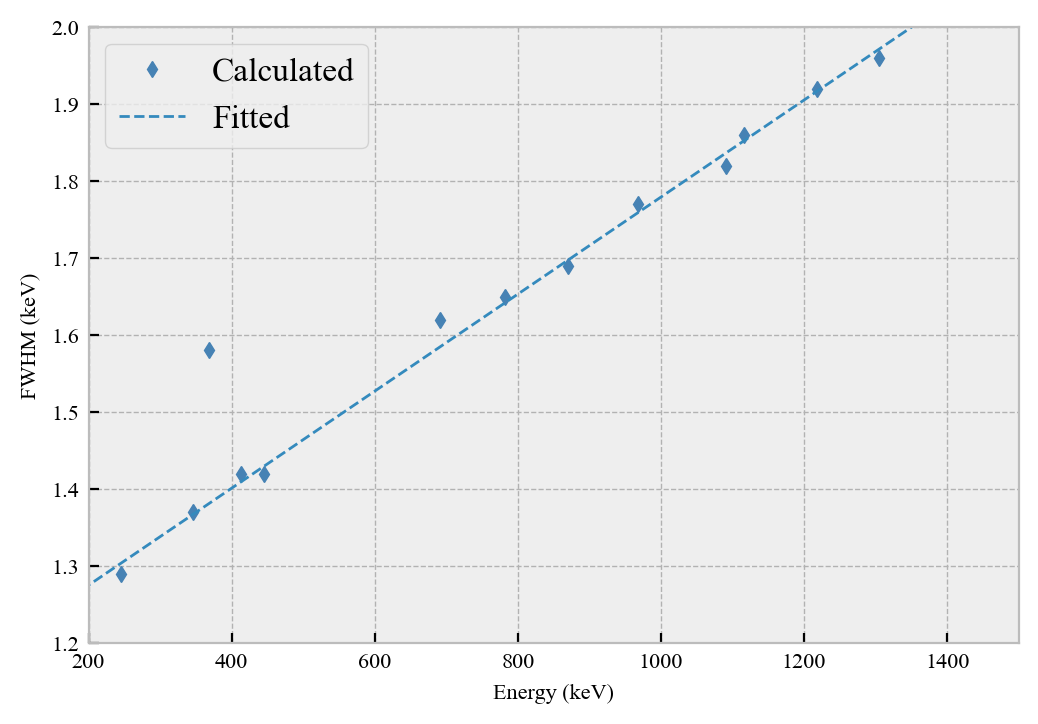

In [34]:
energies = np.array([40.12, 45.40, 121.78, 244.70, 344.28, 367.79, 411.11, 443.98, 688.68, 778.90, 867.39, 964.13, 1085.91, 1089.70, 1112.12, 1212.95, 1299.12, 1304.55, 1413.93])
def energy_in_group(energy):
    return np.any(np.abs(energy-energies)<5)
energy_in_group(50)

energy = [121.97 , 245.18 , 345.14 , 368.58 , 412.26 , 445.31 , 691.12 , 781.87 , 870.62 , 967.79 , 1090.19 , 1116.63 , 1218.00 , 1304.55 , 1413.93]
fwhms = [1.21 , 1.29 , 1.37 , 1.58 , 1.42 , 1.42 , 1.62 , 1.65 , 1.69 , 1.77 , 1.82 , 1.86 , 1.92 , 1.96 , 2.04]
plt.plot(energy, fwhms, 'd', color='steelblue', markersize=4, label='Calculated')
fwhmss = [0.000630*erg+ 1.1493 for erg in energy]
plt.plot(energy, fwhmss, label='Fitted', linestyle='--')

plt.xlim(200, 1500)
plt.ylim(1.2, 2)
plt.xlabel('Energy (keV)')
plt.ylabel('FWHM (keV)')
plt.legend(fontsize= 12)

In [9]:
(gv-gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=True)(bench)).export_to_pandas()

NameError: name 'gv' is not defined

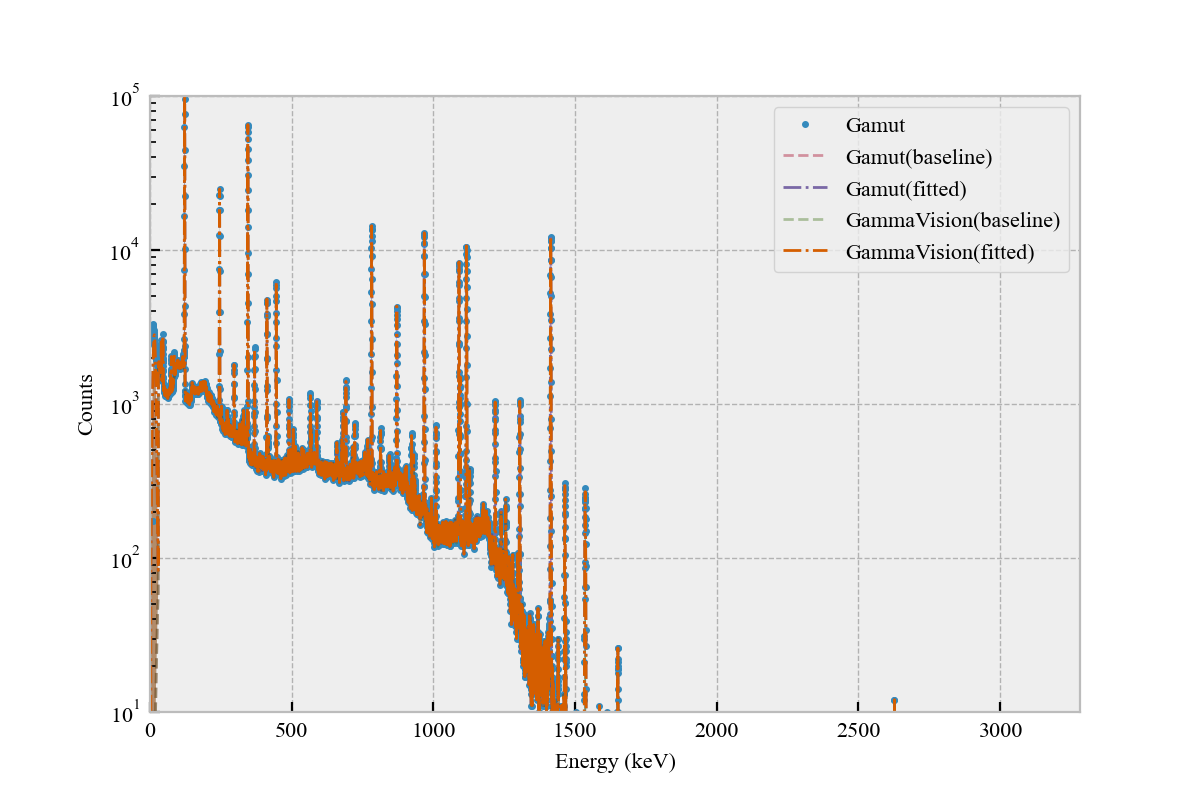

In [ ]:
'''
Author: albertzhang albert.zhangweij@outlook.com
Date: 2024-01-17 17:40:13
Description: 

Copyright (c) 2024 by THU-RSAG, All Rights Reserved. 
'''
%matplotlib widget
plt.close()
bench.label =  'Gamut'
bench.plot('.')
regions = bench0.regions
bench.regions = regions
baseline = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=True)(bench)
# bench.plot_regions()
bench.plot_peaks(baseline=baseline)

gv_energies = [121.97, 245.18, 345.14, 368.58, 412.26, 445.31, 691.12, 781.87, 870.62, 967.79, 1090.19, 1116.63, 1218.00, 1304.55, 1413.93]
gv_stderrs = [2.310497593, 2.524432555, 2.674187029, 2.738367517, 2.823941502, 2.845334998, 3.294598419, 3.315991915, 3.358778908, 3.57271387, 3.786648833, 3.765255336, 3.91500981, 4.000583795, 4.150338268, ]
gv = bench.copy()
for region in gv.regions:
    for peak in region._peaks:
        for i in range(len(gv_energies)):
            if abs(gv.ergcal(peak['center']) - gv_energies[i]) < 1:
                peak['stderr'] = gv_stderrs[i]
gv.label = 'GammaVision'
gv.plot_peaks(baseline=gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=True)(gv))

# bench0.label = 'final'
# bench0.plot()
# bench0.plot_regions()
# bench0.plot_peaks()


# pipenet.get_node(4)[0].plot()
# pipenet.get_node(4)[0].plot_regions()
# pipenet.get_node(4)[0].plot_peaks()
# spec = pipenet.get_node(3)[0]
# spec.plot()
# spec.plot_regions()
# spec.plot_peaks()
plt.yscale('log')
plt.legend()
plt.ylim(10, 1E5)
# plt.xlim(300, 500)
plt.show()

In [ ]:
# pipenet([bench])
out = pipenet.get_node(4)[0]
df = out.export_to_pandas()
df.to_excel('Eu152_exp_Nie.xlsx')
df

,left,right,energy,location,height,stderr,area,sig_area2,fitness
0,13,145,14.791627,75,2810.973961,22.513161,158629.238645,790.904251,0.761074
1,185,209,39.833502,200,1036.163059,2.902147,7537.676252,116.121868,0.938826
2,219,239,45.242547,227,1394.884985,2.320199,8112.478112,246.566330,0.990956
3,219,239,46.444557,233,514.646897,2.230968,2878.012436,283.106026,0.990956
4,360,368,72.688442,364,329.332172,1.716062,1416.632038,121.375327,0.955090
5,370,381,74.892127,375,783.916814,2.333526,4585.350048,197.706668,0.984299
6,409,433,84.708542,424,642.610065,3.084414,4968.326714,111.141770,0.904086
7,580,628,121.970852,610,124980.707926,2.289128,717138.490699,894.526313,0.999919
8,1214,1235,245.176877,1225,24067.863038,2.496591,150617.308720,456.865079,0.999868
9,1470,1495,296.662972,1482,1210.685334,2.598518,7885.822777,102.249803,0.993430
